In [150]:
import sys
sys.path.append("../src")
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

from text_cleaning import clean_text
from nltk.tokenize import word_tokenize
from stylographic_features import get_stylographic_feat

from style_point_cloud import style_point_cloud
from clustering import ClusterAuthors

from distances import mod_hausdorff_dist

from tqdm import tqdm 

tqdm.pandas()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
df = pd.read_pickle("../data/csCL2000.pkl")

In [7]:
df.drop(["index", "pdf_link_no_export",
 "path_to_pdf", "pdf_metadata"], axis=1, inplace=True)

In [49]:
# Example of text cleaning
text1 = df.text_body[0]
text1 = clean_text(text1)

text2 = df.text_body[1]
text2 = clean_text(text2)

tokenized_text1 = word_tokenize(text1)
tokenized_text2 = word_tokenize(text2)
print(len(tokenized_text1), 
        len(tokenized_text2))

1732 4578


In [61]:
s_vec1 = style_point_cloud(text1, max_tokens = 1500,
 window_size=500, window_overlap=400,)
            #reduce="pca", redu_kwargs={"n_components": 4})
s_vec2 = style_point_cloud(text2,
 window_size=500, window_overlap=400, max_tokens = 2000, )
            #reduce="pca", redu_kwargs={"n_components": 4})

In [62]:
mod_hausdorff_dist(s_vec1, s_vec2)

68.12366756919658

# 3-authors cluster

In [151]:
author_list = ["Diptesh Kanojia", "Bing Liu", "Hannes Westermann"]

In [152]:
mask = df.authors.apply(lambda x: True if set(x[:2]).intersection(author_list)else False)

In [153]:
df = df[mask].copy()

In [154]:
df["point_cloud"] = df.text_body.progress_apply(lambda text: 
    style_point_cloud(text, window_size=600, window_overlap=550,
        max_tokens=3_000))

100%|██████████| 14/14 [00:15<00:00,  1.12s/it]


In [ ]:
cl = ClusterAuthors()

In [ ]:
df["point_cloud"]

In [ ]:
doc_lengths = df.point_cloud.apply(len)
doc_labels = [[i]*n_chunks for i, n_chunks in 
                zip(range(len(doc_lengths)), doc_lengths)]
doc_labels = np.array(doc_labels).flatten()

In [155]:
from itertools import combinations, permutations

In [158]:
list(permutations(set([1, 2, 3])))

[(1, 2, 3), (1, 3, 2), (2, 1, 3), (2, 3, 1), (3, 1, 2), (3, 2, 1)]

In [120]:
pca = PCA(n_components=2)
scaler = StandardScaler()

data = pca.fit_transform(scaler.fit_transform(np.vstack(df["point_cloud"].to_numpy())))

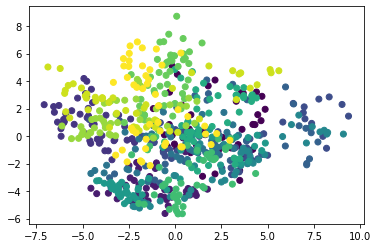

In [122]:
plt.scatter(data[:, 0], data[:, 1], c=doc_labels);

In [145]:
def get_auth_label(auth_list): 
    if "Diptesh Kanojia" in auth_list:
        return 0
    elif "Hannes Westermann" in auth_list:
        return 1
    elif "Bing Liu" in auth_list:
        return 2

In [146]:
doc_lengths = df.point_cloud.apply(len)
auths = df.authors.apply(get_auth_label)
auth_labels = [[i]*n_chunks for i, n_chunks in 
                zip(auths, doc_lengths)]
auth_labels = np.array(auth_labels).flatten()

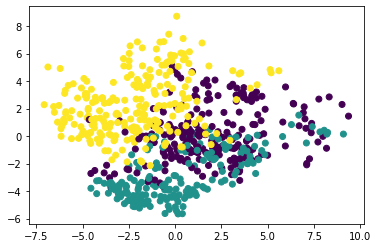

In [128]:
plt.scatter(data[:, 0], data[:, 1], c=auth_labels);

In [149]:
from collections import Counter


Counter(np.array([1, 1, 5, 5, 2, 1])).most_common()

[(1, 3), (5, 2), (2, 1)]

In [134]:
frag_dists = np.zeros((len(doc_lengths), len(doc_lengths)))
curr_i = 0
for i_doc, doc1 in tqdm(enumerate(df.point_cloud), total=df.point_cloud.shape[0]):
    for j_doc, doc2 in enumerate(df.point_cloud):
        if i_doc == j_doc:
            continue
        frag_dists[i_doc, j_doc] = mod_hausdorff_dist(doc1, doc2)

100%|██████████| 14/14 [00:00<00:00, 741.05it/s]


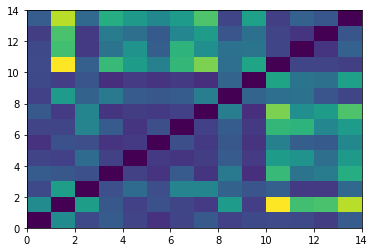

In [142]:
plt.pcolormesh(frag_dists);